In [109]:
import mlflow
from mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import joblib
import os
import inference

In [2]:
client = MlflowClient()

In [3]:
experiment = client.get_experiment_by_name("n_clusters_investigation")
runs = client.search_runs(experiment_ids=experiment.experiment_id)


In [18]:
results = []
for run in runs:
    run_id = run.info.run_id
    metrics = run.data.metrics
    params = run.data.params
    
    inertia = metrics.get("inertia")
    silhouette_score = metrics.get("silhouette_score")
    n_clusters = params.get("n_clusters")
    
    results.append({
        "run_id": run.info.run_id,
        "n_clusters": int(n_clusters),
        "inertia": inertia,
        "silhouette_score": silhouette_score
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="n_clusters").reset_index(drop=True)

In [19]:
results_df

,run_id,n_clusters,inertia,silhouette_score
0,2dba2dbf1b7248cdbe2950385a8d180c,2,3.386382e+06,0.256647
1,b224b747a88743f6ab0476f26b44a2c5,3,2.731229e+06,0.276347
2,35f49cc4628c4334b463f8f55a61684a,4,2.520260e+06,0.260060
3,58885de0645643769e515fa1502bc9f2,5,2.168251e+06,0.184338
4,058beb3d306f4ed7989355dd4d6c31e1,6,2.253367e+06,0.183917
5,f6935bd10f3742c1b3ea87eaf044a610,7,1.860495e+06,0.211387
6,d563aee98a0e486b9bed0fbb93c37191,8,1.736646e+06,0.195442
7,95094239b60d410ab907ab04d9a9725c,9,1.628547e+06,0.204209
8,d044d848983a49dbb98c11e3b674b8df,10,1.579398e+06,0.199833


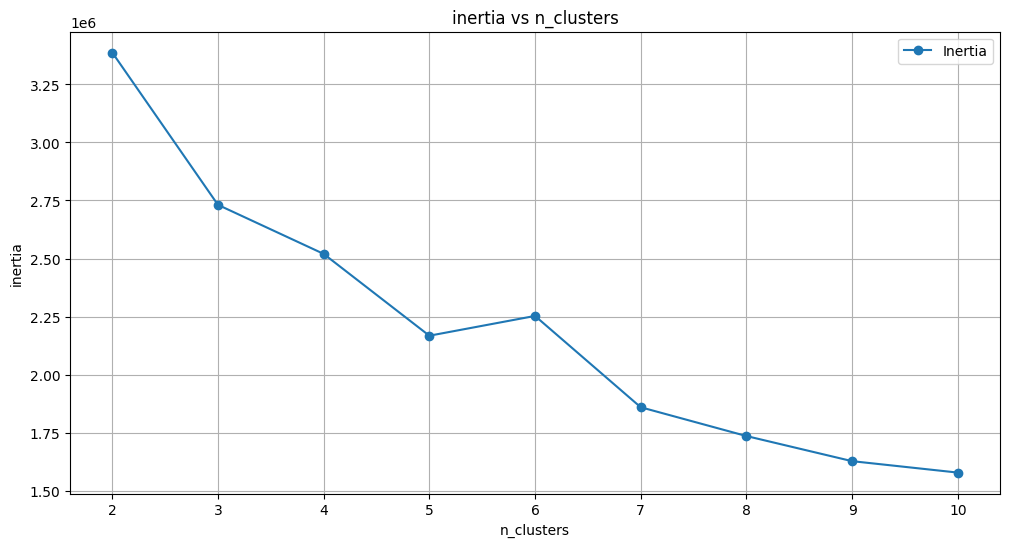

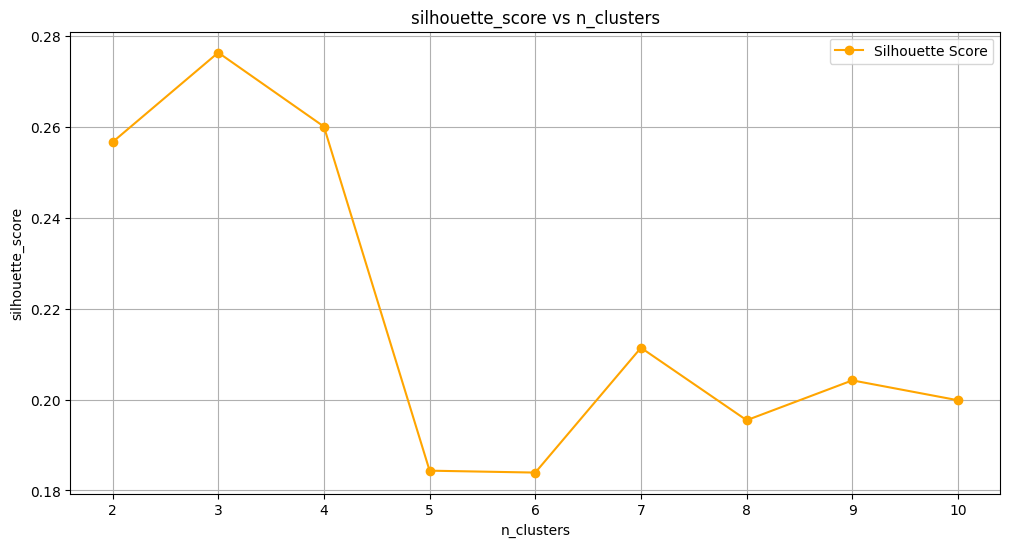

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(results_df["n_clusters"], results_df["inertia"], marker='o', label='Inertia')
plt.title("inertia vs n_clusters")
plt.xlabel("n_clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(results_df["n_clusters"], results_df["silhouette_score"], marker='o', label='Silhouette Score', color='orange')
plt.title("silhouette_score vs n_clusters")
plt.xlabel("n_clusters")
plt.ylabel("silhouette_score")
plt.grid(True)
plt.legend()
plt.show()

- Inertia: elbow point at 5 clusters.
- Silhouette Score: peaks at 3 clusters (better interpretability and definition of clusters than 5)

In [3]:
client = MlflowClient()
experiment = client.get_experiment_by_name("two_clusterings")
runs = client.search_runs(experiment_ids=experiment.experiment_id)
for run in runs:
    print(run.data.params.get('n_clusters'))

5
3


In [5]:
client = MlflowClient()
experiment = client.get_experiment_by_name("two_clusterings")
runs = client.search_runs(experiment_ids=experiment.experiment_id)
for run in runs:
    inference.run_inference_pipeline(run.info.run_id, "./consumers_features.parquet.gzip", f"./clustered_{int(run.data.params.get('n_clusters'))}_{run.info.run_id}.parquet.gzip")

In [8]:
import utils as UT

In [21]:
clustered_data_3 = UT.load_from_parquet("./clustered_3_b1dffefa3ad844e3bc3bc867199845ff.parquet.gzip")
clustered_data_5 = UT.load_from_parquet("./clustered_5_00f3c0128a6c43eeac2da0edfc2d7b75.parquet.gzip")

C:\Users\a.iliopoulos_xe\AppData\Local\Temp\ipykernel_10428\1256135539.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


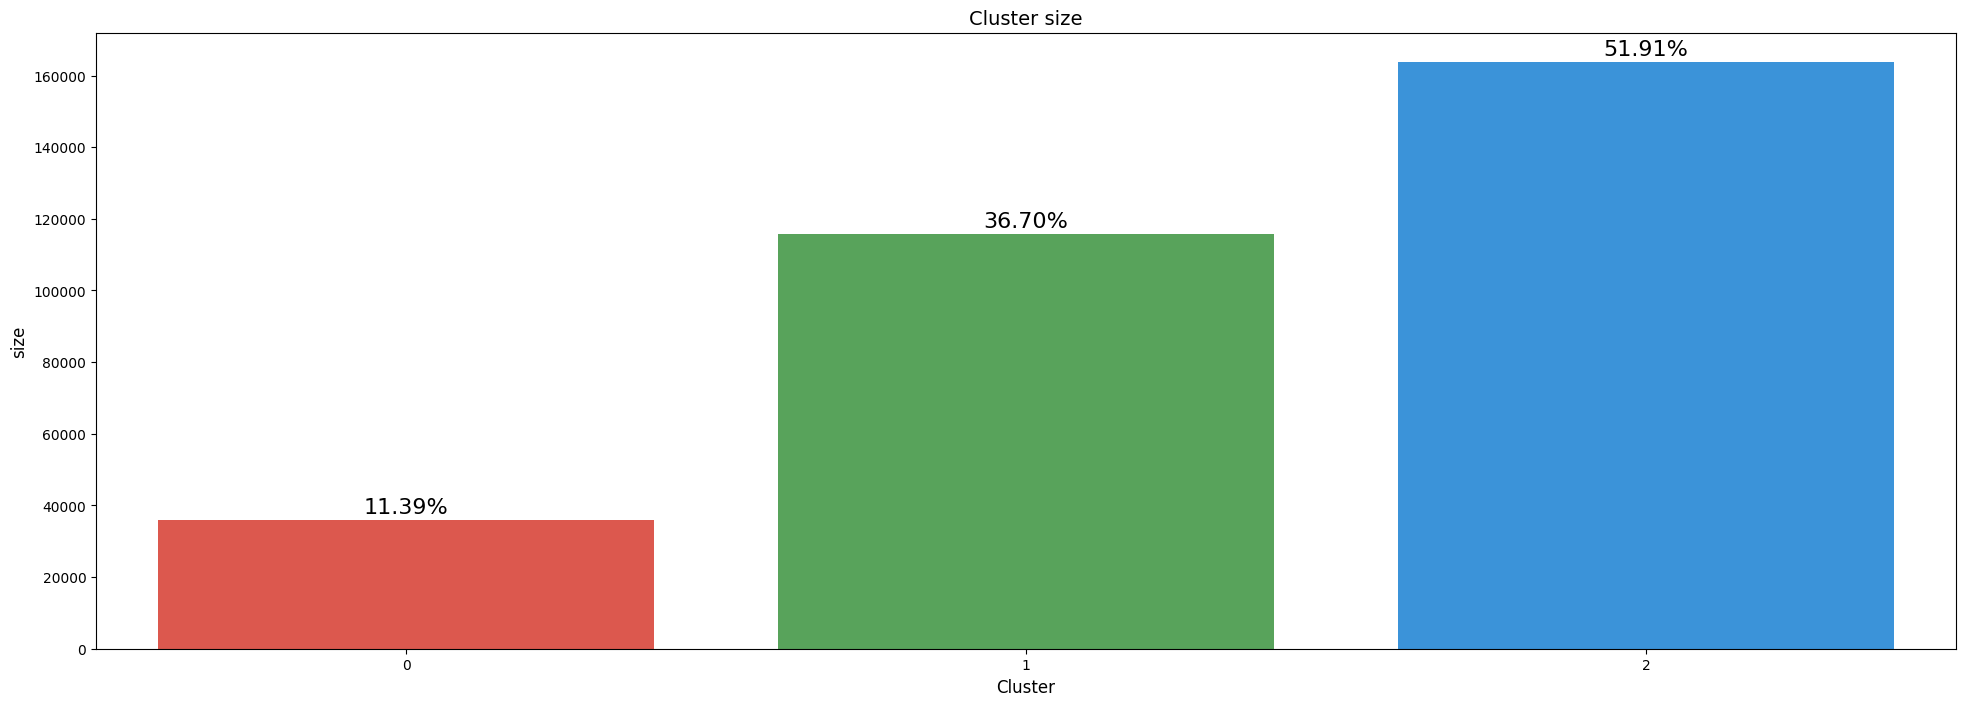

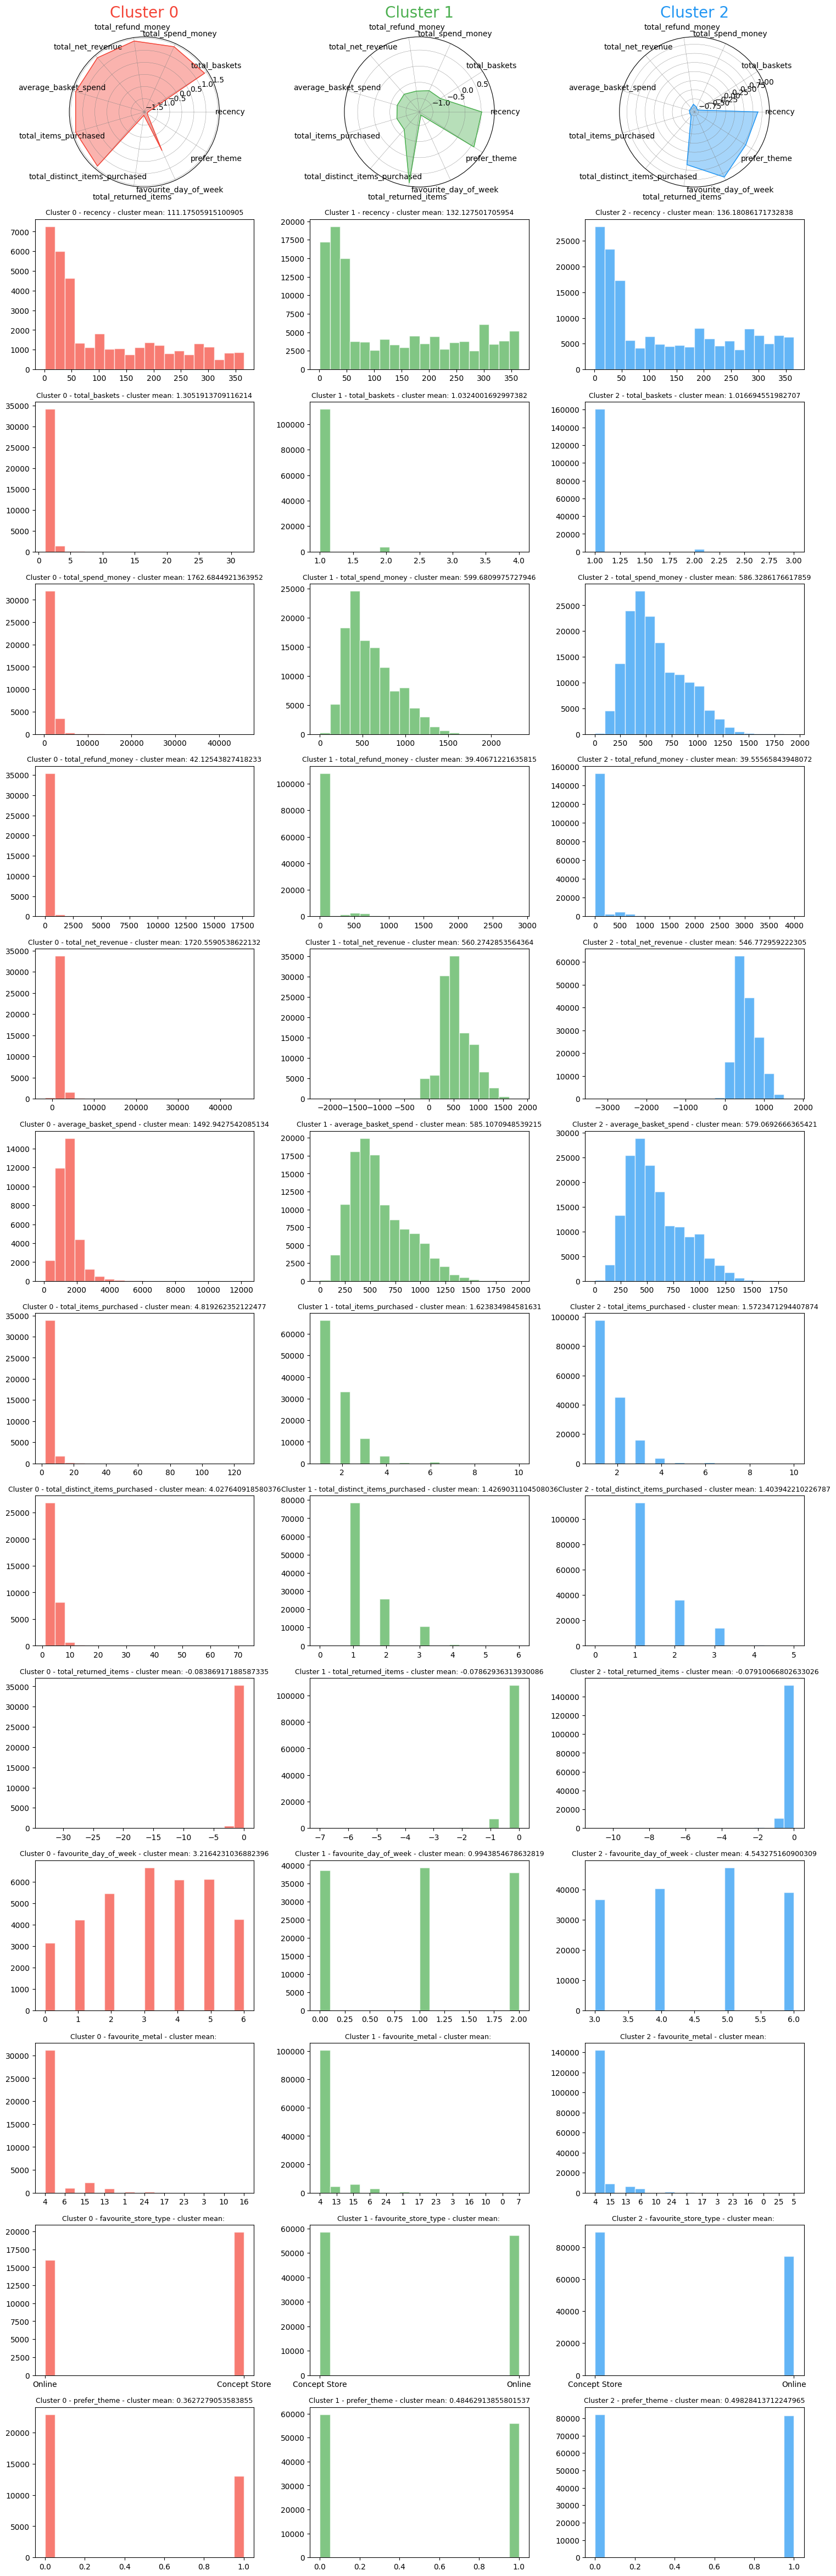

C:\Users\a.iliopoulos_xe\AppData\Local\Temp\ipykernel_10428\1256135539.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


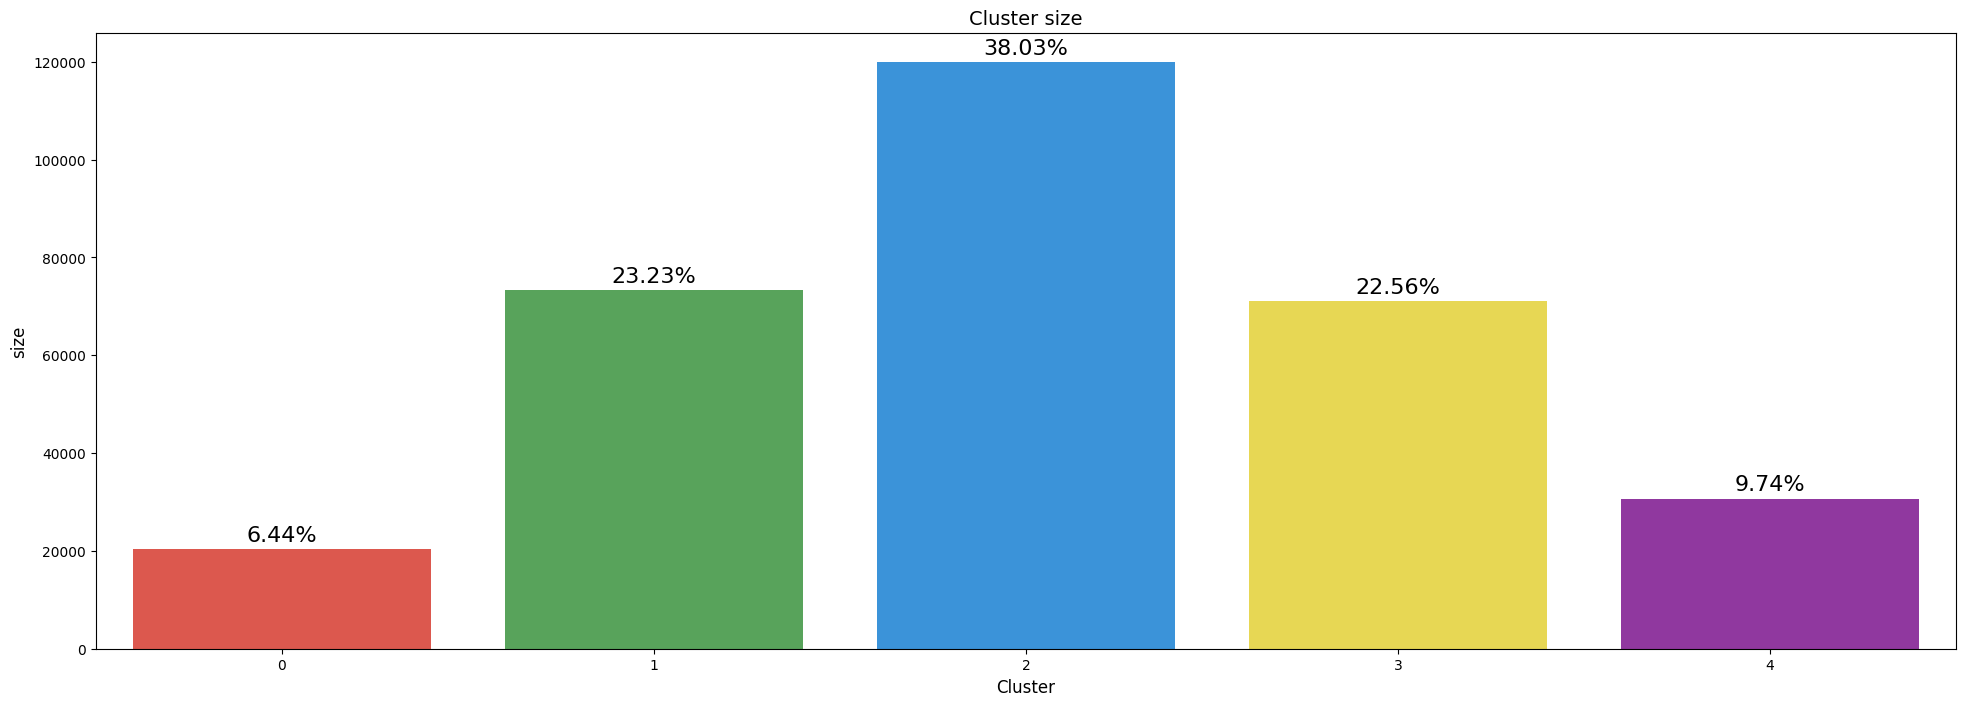

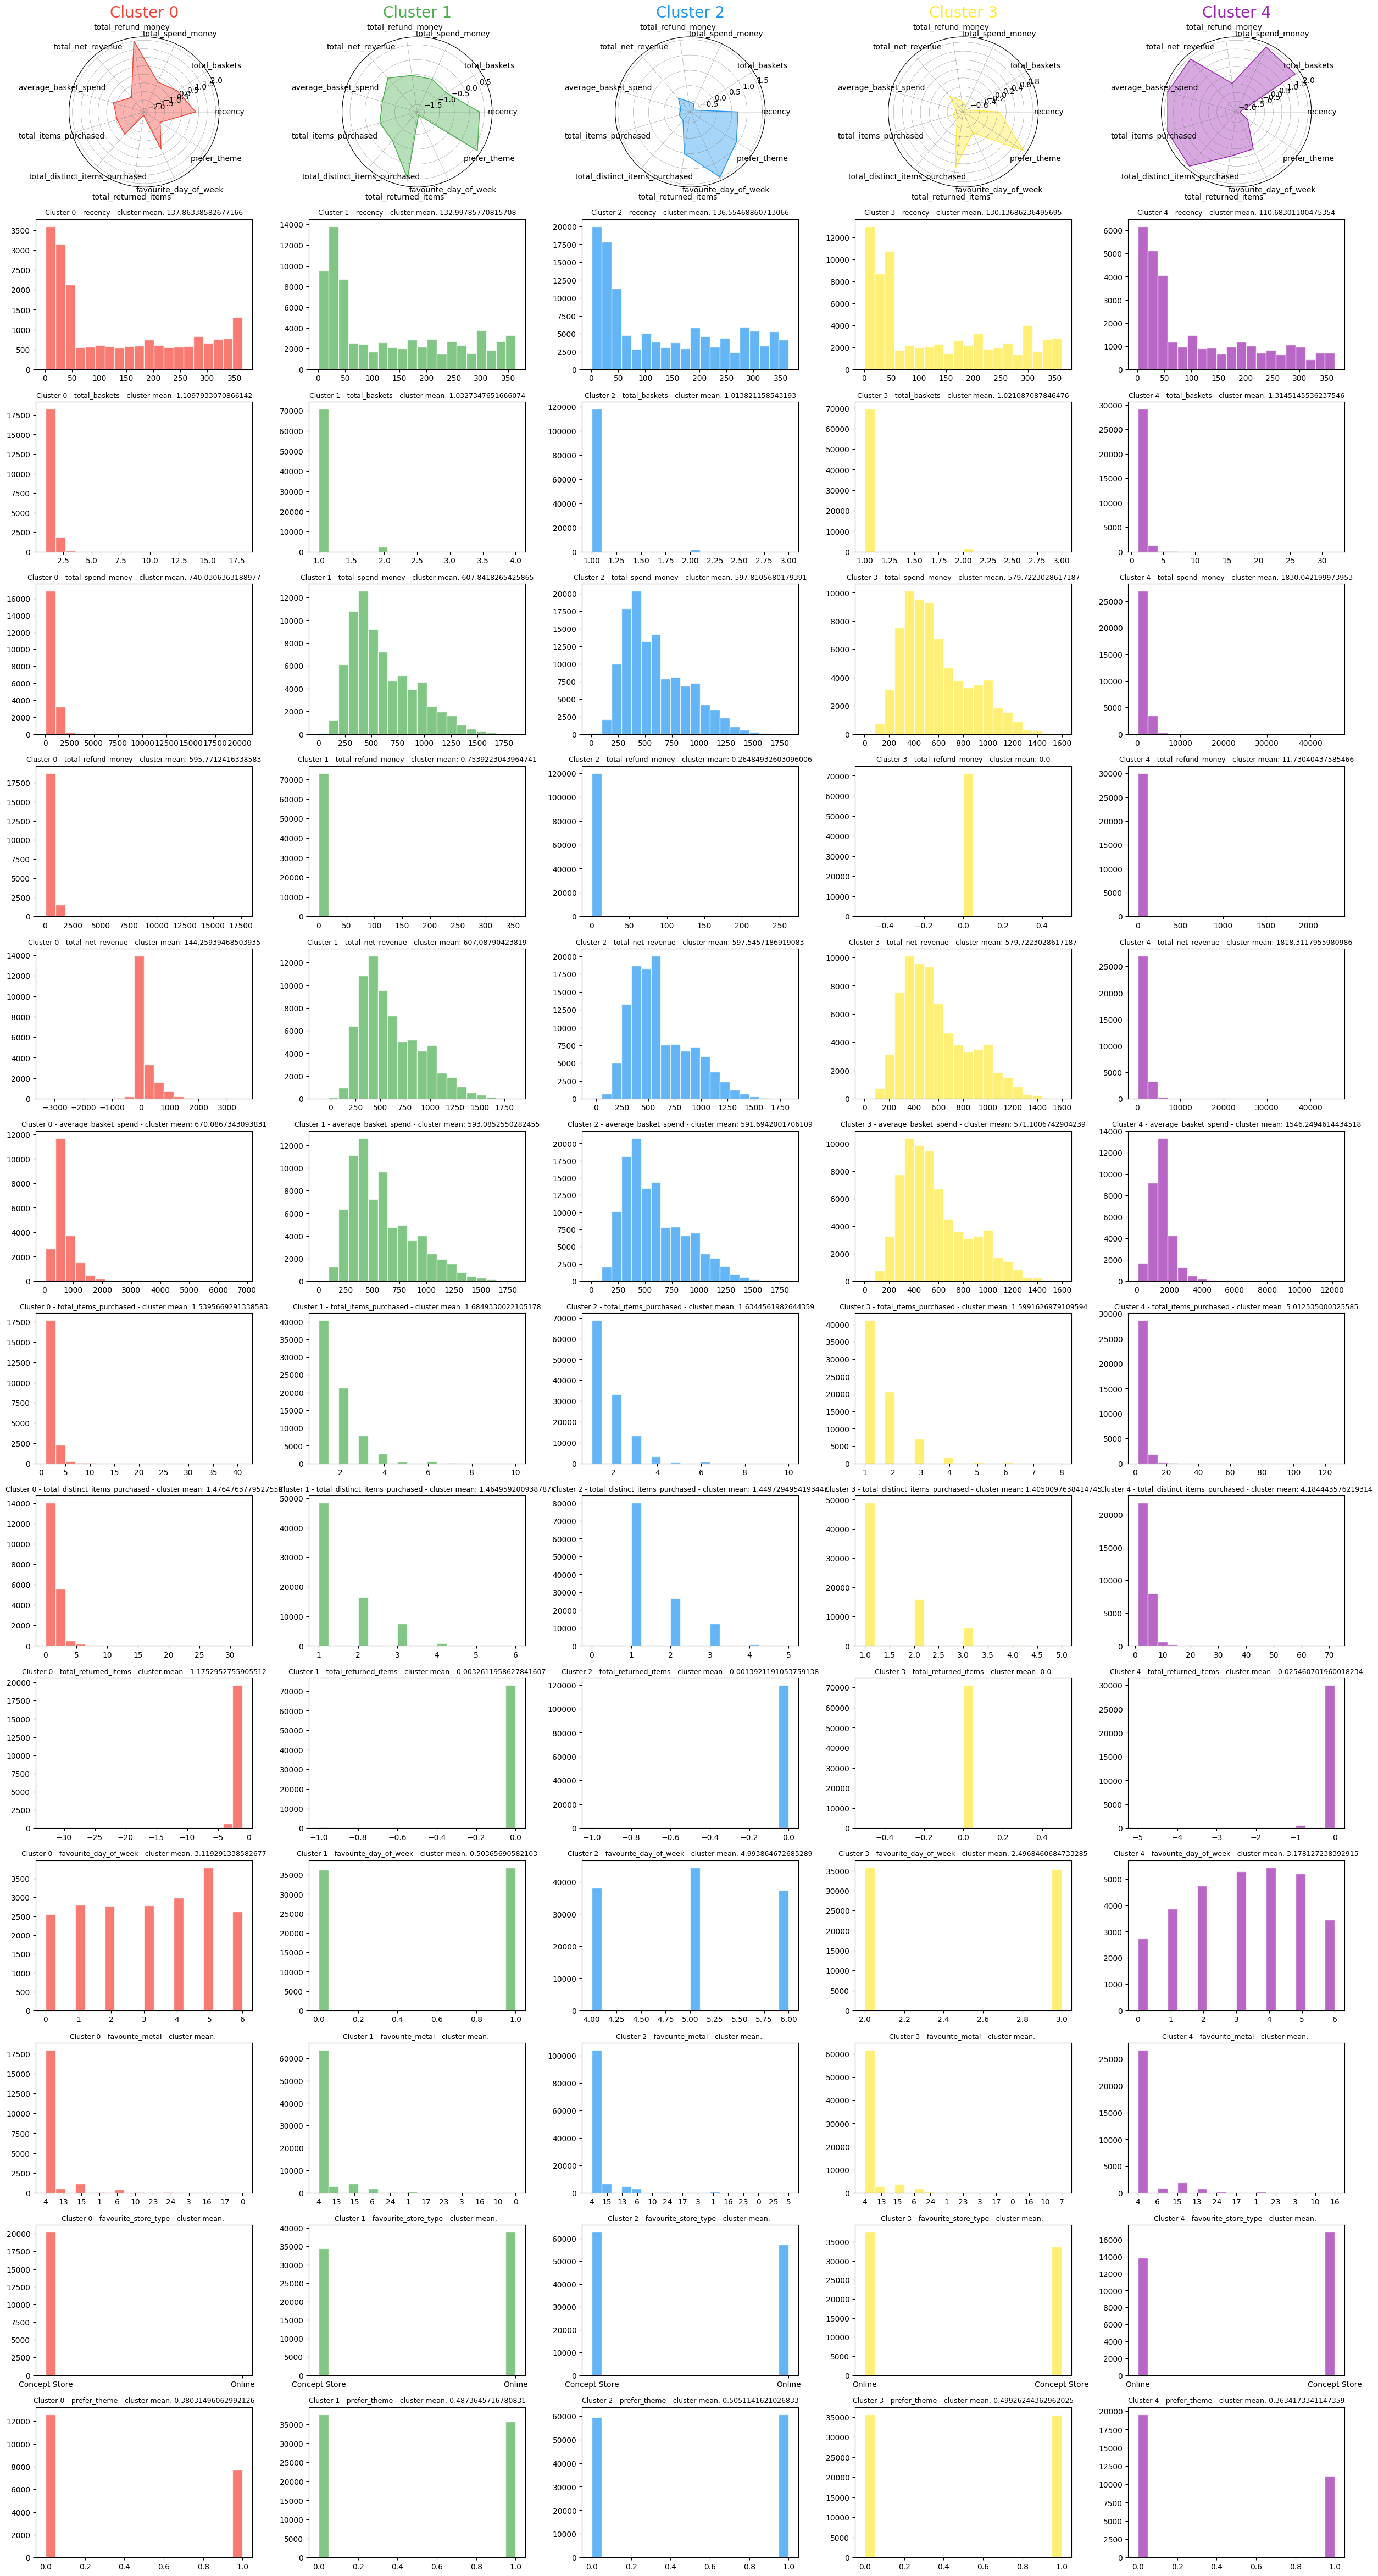

In [123]:
google_material_colors = [
    (244, 67, 54),  # Red
    (76, 175, 80),  # Green
    (33, 150, 243), # Blue
    (255, 235, 59), # Yellow
    (156, 39, 176), # Purple
]
pastel_colors = [
    (255, 179, 186), # Pastel Red
    (186, 255, 201), # Pastel Green
    (179, 221, 255), # Pastel Blue
    (255, 253, 186), # Pastel Yellow
    (214, 186, 255), # Pastel Purple
]

color_list = [(r/255, g/255, b/255) for r, g, b in google_material_colors]

features = ['recency', 'total_baskets', 'total_spend_money', 
            'total_refund_money', 'total_net_revenue', 
            'average_basket_spend', 'total_items_purchased',
            'total_distinct_items_purchased', 'total_returned_items',
            'favourite_day_of_week', 'favourite_metal', 'favourite_store_type',
            'prefer_theme']


for n_clusters, dataset in [(3,clustered_data_3), (5, clustered_data_5)]:
    cluster_counts = dataset['clustered_cluster'].value_counts().reset_index().sort_values(by="clustered_cluster", ascending=True)
    cluster_counts.columns = ['clustered_cluster', 'count']
    total_rows = len(dataset)
    cluster_counts['percentage'] = round(100 * cluster_counts['count'] / total_rows,2)
    plt.figure(figsize=(24, 8))
    barplot = sns.barplot(
        data=cluster_counts,
        x='clustered_cluster',
        y='count',
        palette=color_list[:n_clusters]
    )

    ymin, ymax = barplot.get_ylim()

    for i, bar in enumerate(barplot.patches):
        height = bar.get_height()
        percentage = cluster_counts.loc[cluster_counts['clustered_cluster'] == i, 'percentage'].values[0]
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.1*(ymax - ymin) / (len(ax.get_yticks()) - 1),
            f'{percentage:.2f}%',
            ha='center',
            fontsize=16
        )

    plt.title('Cluster size', fontsize=14)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('size', fontsize=12)

    plt.show()


    n_cols = n_clusters
    n_rows = len(features)+1
    fig = plt.figure(figsize=(5 * n_clusters, 50))
    gs = GridSpec(n_rows + 1, n_cols, figure=fig)
    # fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_clusters, 45))
    aggregated_data = dict()
    for ind_i, feature in enumerate(features):
        x_min = dataset[feature].min()
        x_max = dataset[feature].max()
        row_aggregated_data = []
        for ind_j, cluster in enumerate(range(n_clusters)):

            data = dataset[dataset['clustered_cluster'] == cluster][feature]
            cluster_mean = str(float(data.mean())) if pd.api.types.is_numeric_dtype(dataset[feature]) else ""
            ax = fig.add_subplot(gs[ind_i+1, ind_j])
            ax.hist(data, bins=20, color=color_list[ind_j], edgecolor='w', alpha=0.7)
            ax.set_title(f'Cluster {cluster} - {feature} - cluster mean: {cluster_mean}', fontsize=9)
            ax.set_xlabel('')
            ax.set_ylabel('')
            if pd.api.types.is_numeric_dtype(dataset[feature]):
                row_aggregated_data.append(data.mean())
        if pd.api.types.is_numeric_dtype(dataset[feature]):
            aggregated_data[feature] = row_aggregated_data
    
    df = pd.DataFrame(aggregated_data)
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df, columns=pd.DataFrame(aggregated_data).columns)
    labels=np.array(df.columns)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    labels = np.concatenate((labels, [labels[0]]))
    angles += angles[:1]
    
    for i, color in enumerate(color_list[:n_clusters]):
        ax = fig.add_subplot(gs[0, i], polar=True)
        data = df.loc[i].tolist()
        data += data[:1]
        ax.fill(angles, data, color=color, alpha=0.4)
        ax.plot(angles, data, color=color, linewidth=1, linestyle='solid')
        ax.set_title(f'Cluster {i}', size=20, color=color, y=1.1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels[:-1])
        ax.grid(color='grey', linewidth=0.3)
    
                
    plt.tight_layout()
    plt.show()